# Two Dimensional Histogram Filter - Your First Feature (and your first bug).
Writing code is important. But a big part of being on a self driving car team is working with a **large** existing codebase. On high stakes engineering projects like a self driving car, you will probably have to earn the trust of your managers and coworkers before they'll let you make substantial changes to the code base. 

A typical assignment for someone new to a team is to make progress on a backlog of bugs. So with that in mind, that's what you will be doing for your first project in the Nanodegree.

You'll go through this project in a few parts:

1. **Explore the Code** - don't worry about bugs at this point. The goal is to get a feel for how this code base is organized and what everything does.
2. **Implement a Feature** - write code that gets the robot moving correctly.
3. **Fix a Bug** - Implementing motion will reveal a bug which hadn't shown up before. Here you'll identify what the bug is and take steps to reproduce it. Then you'll identify the cause and fix it.


## Part 1: Exploring the code
In this section you will just run some existing code to get a feel for what this localizer does.

You can navigate through this notebook using the arrow keys on your keyboard. You can run the code in a cell by pressing **`Ctrl + Enter`**

Navigate through the cells below. In each cell you should

1. Read through the code. It's okay to not understand everything at this point. 
2. Make a guess about what will happen when you run the code. 
3. Run the code and compare what you see with what you expected. 
4. When you get to a **TODO** read the instructions carefully and complete the activity.



In [1]:
# This code "imports" code from some of the other files we've written
# in this directory. Specifically simulate.py and helpers.py
import simulate as sim
import helpers
import localizer

# Don't worry too much about this code for now...
from __future__ import division, print_function
%load_ext autoreload
%autoreload 2

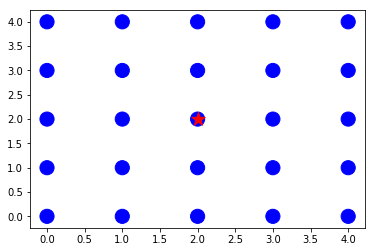

In [2]:
# This code defines a 5x5 robot world as well as some other parameters
# which we will discuss later. It then creates a simulation and shows 
# the initial beliefs. 
R = 'r'
G = 'g'
grid = [
    [R,G,G,G,R],
    [G,G,R,G,R],
    [G,R,G,G,G],
    [R,R,G,R,G],
    [R,G,R,G,R],
]
blur = 0.05
p_hit = 200.0
simulation = sim.Simulation(grid, blur, p_hit)
simulation.show_beliefs()

Run the code below multiple times by repeatedly pressing Ctrl + Enter.

After each run observe how the state has changed. 

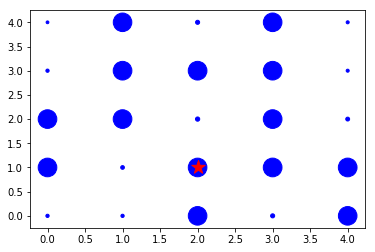

In [3]:
simulation.run(1)
simulation.show_beliefs()

What do you think this call to `run` is doing? Look at the code in **`simulate.py`** to find out (remember - you can see other files in the current directory by clicking on the `jupyter` logo in the top left of this notebook).

Spend a few minutes looking at the `run` method and the methods it calls to get a sense for what's going on.

#### What am I looking at?

The red star shows the robot's true position. The blue circles indicate the strength of the robot's belief that it is at any particular location.

Ideally we want the biggest blue circle to be at the same position as the red star.

In [4]:
# We will provide you with the function below to help you look
# at the raw numbers.

def show_rounded_beliefs(beliefs):
    for row in beliefs:
        for belief in row:
            print("{:0.3f}".format(belief), end="  ")
        print()
        
# The {:0.3f} notation is an example of "string 
# formatting" in Python. You can learn more about string 
# formatting at https://pyformat.info/

In [5]:
show_rounded_beliefs(simulation.beliefs)

0.002  0.069  0.003  0.069  0.002  
0.002  0.070  0.070  0.069  0.002  
0.069  0.070  0.004  0.070  0.003  
0.069  0.003  0.069  0.070  0.070  
0.002  0.002  0.069  0.003  0.069  


_____

## Part 2: Implement a 2D sense function.
As you can see, the robot's beliefs aren't changing. No matter how many times we call the simulation's sense method, nothing happens. The beliefs remain uniform.

### Instructions
1. Open `localizer.py` and complete the `sense` function.
3. Run the code in the cell below to import the localizer module (or reload it) and then test your sense function.
4. If the test passes, you've successfully implemented your first feature! Keep going with the project. If your tests don't pass (they likely won't the first few times you test), keep making modifications to the `sense` function until they do!

In [6]:
reload(localizer)
def test_sense():
    R = 'r'
    _ = 'g'

    simple_grid = [
        [_,_,_],
        [_,R,_],
        [_,_,_]
    ]

    p = 1.0 / 9
    initial_beliefs = [
        [p,p,p],
        [p,p,p],
        [p,p,p]
    ]

    observation = R

    expected_beliefs_after = [
        [1/11, 1/11, 1/11],
        [1/11, 3/11, 1/11],
        [1/11, 1/11, 1/11]
    ]

    p_hit  = 3.0
    p_miss = 1.0
    beliefs_after_sensing = localizer.sense(
        observation, simple_grid, initial_beliefs, p_hit, p_miss)

    if helpers.close_enough(beliefs_after_sensing, expected_beliefs_after):
        print("Tests pass! Your sense function is working as expected")
        return
    
    elif not isinstance(beliefs_after_sensing, list):
        print("Your sense function doesn't return a list!")
        return
        
    elif len(beliefs_after_sensing) != len(expected_beliefs_after):
        print("Dimensionality error! Incorrect height")
        return
              
    elif len(beliefs_after_sensing[0] ) != len(expected_beliefs_after[0]):
        print("Dimensionality Error! Incorrect width")
        return
    
    elif beliefs_after_sensing == initial_beliefs:
        print("Your code returns the initial beliefs.")
        return
        
    total_probability = 0.0
    for row in beliefs_after_sensing:
        for p in row:
            total_probability += p
    if abs(total_probability-1.0) > 0.001:
        
        print("Your beliefs appear to not be normalized")
        return
    
    print("Something isn't quite right with your sense function")

test_sense()

Tests pass! Your sense function is working as expected


## Integration Testing
Before we call this "complete" we should perform an **integration test**. We've verified that the sense function works on it's own, but does the localizer work overall?

Let's perform an integration test. First you you should execute the code in the cell below to prepare the simulation environment.

In [7]:
from simulate import Simulation
import simulate as sim
import helpers
reload(localizer)
reload(sim)
reload(helpers)

R = 'r'
G = 'g'
grid = [
    [R,G,G,G,R,R,R],
    [G,G,R,G,R,G,R],
    [G,R,G,G,G,G,R],
    [R,R,G,R,G,G,G],
    [R,G,R,G,R,R,R],
    [G,R,R,R,G,R,G],
    [R,R,R,G,R,G,G],
]

# Use small value for blur. This parameter is used to represent
# the uncertainty in MOTION, not in sensing. We want this test
# to focus on sensing functionality
blur = 0.1
p_hit = 100.0
simulation = sim.Simulation(grid, blur, p_hit)

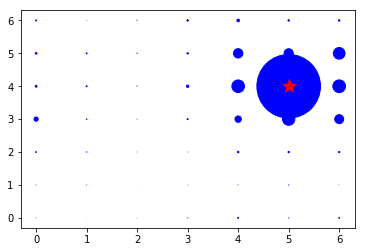

In [30]:
# Use control+Enter to run this cell many times and observe how 
# the robot's belief that it is in each cell (represented by the
# size of the corresponding circle) changes as the robot moves.
# The true position of the robot is given by the red star.

# Run this cell about 15-25 times and observe the results
simulation.run(1)
simulation.show_beliefs()

# If everything is working correctly you should see the beliefs
# converge to a single large circle at the same position as the 
# red star. Though, if your sense function is implemented correctly
# and this output is not converging as expected.. it may have to do
# with the `move` function bug; your next task!
#
# When you are satisfied that everything is working, continue
# to the next section

## Part 3: Identify and Reproduce a Bug
Software has bugs. That's okay.

A user of your robot called tech support with a complaint

> "So I was using your robot in a square room and everything was fine. Then I tried loading in a map for a rectangular room and it drove around for a couple seconds and then suddenly stopped working. Fix it!"

Now we have to debug. We are going to use a systematic approach.

1. Reproduce the bug
2. Read (and understand) the error message (when one exists)
3. Write a test that triggers the bug.
4. Generate a hypothesis for the cause of the bug.
5. Try a solution. If it fixes the bug, great! If not, go back to step 4.

### Step 1: Reproduce the bug
The user said that **rectangular environments** seem to be causing the bug. 

The code below is the same as the code you were working with when you were doing integration testing of your new feature. See if you can modify it to reproduce the bug.

In [32]:
from simulate import Simulation
import simulate as sim
import helpers
reload(localizer)
reload(sim)
reload(helpers)

R = 'r'
G = 'g'

grid = [ 
    [R,G,G,G,R,R,R],
    [G,G,R,G,R,G,R],
    [G,R,G,G,G,G,R],
    [R,R,G,R,G,G,G],
]

blur = 0.001
p_hit = 100.0
simulation = sim.Simulation(grid, blur, p_hit)

# remember, the user said that the robot would sometimes drive around for a bit...
# It may take several calls to "simulation.run" to actually trigger the bug.
simulation.run(1)
simulation.show_beliefs()

IndexError: list index out of range

In [33]:
simulation.run(1)

IndexError: list index out of range

### Step 2: Read and Understand the error message
If you triggered the bug, you should see an error message directly above this cell. The end of that message should say:

```
IndexError: list index out of range
```

And just above that you should see something like

```
path/to/your/directory/localizer.pyc in move(dy, dx, beliefs, blurring)
     38             new_i = (i + dy ) % width
     39             new_j = (j + dx ) % height
---> 40             new_G[int(new_i)][int(new_j)] = cell
     41     return blur(new_G, blurring)
```

This tells us that line 40 (in the move function) is causing an `IndexError` because "list index out of range".

If you aren't sure what this means, use Google! 

Copy and paste `IndexError: list index out of range` into Google! When I do that, I see something like this:

![Search Results](http://i.imgur.com/gleBmBy.png)

Browse through the top links (often these will come from stack overflow) and read what people have said about this error until you are satisfied you understand how it's caused.

### Step 3: Write a test that reproduces the bug
This will help you know when you've fixed it and help you make sure you never reintroduce it in the future. You might have to try many potential solutions, so it will be nice to have a single function to call to confirm whether or not the bug is fixed

### Step 4: Generate a Hypothesis
In order to have a guess about what's causing the problem, it will be helpful to use some Python debuggin tools

The `pdb` module (`p`ython `d`e`b`ugger) will be helpful here!

#### Setting up the debugger 
1. Open `localizer.py` and uncomment the line to the top that says `import pdb`
2. Just before the line of code that is causing the bug `new_G[int(new_i)][int(new_j)] = cell`, add a new line of code that says `pdb.set_trace()`
3. Run your test by calling your test function (run the cell below this one)
4. You should see a text entry box pop up! For now, type `c` into the box and hit enter to **c**ontinue program execution. Keep typing `c` and enter until the bug is triggered again

In [37]:
test_robot_works_in_rectangle_world()

> /home/workspace/localizer.py(47)move()
-> new_G[int(new_i)][int(new_j)] = cell
(Pdb) c
> /home/workspace/localizer.py(46)move()
-> pdb.set_trace()
(Pdb) c
> /home/workspace/localizer.py(47)move()
-> new_G[int(new_i)][int(new_j)] = cell
(Pdb) c
> /home/workspace/localizer.py(46)move()
-> pdb.set_trace()
(Pdb) c
> /home/workspace/localizer.py(47)move()
-> new_G[int(new_i)][int(new_j)] = cell
(Pdb) c
> /home/workspace/localizer.py(46)move()
-> pdb.set_trace()
(Pdb) c
> /home/workspace/localizer.py(47)move()
-> new_G[int(new_i)][int(new_j)] = cell
(Pdb) c
> /home/workspace/localizer.py(46)move()
-> pdb.set_trace()
(Pdb) c
> /home/workspace/localizer.py(47)move()
-> new_G[int(new_i)][int(new_j)] = cell
(Pdb) c
> /home/workspace/localizer.py(46)move()
-> pdb.set_trace()
(Pdb) c
> /home/workspace/localizer.py(47)move()
-> new_G[int(new_i)][int(new_j)] = cell
(Pdb) c
> /home/workspace/localizer.py(46)move()
-> pdb.set_trace()
(Pdb) c
> /home/workspace/localizer.py(47)move()
-> new_G[int(new_

KeyboardInterrupt: 

#### Using the debugger
The debugger works by pausing program execution wherever you write `pdb.set_trace()` in your code. You also have access to any variables which are accessible from that point in your code. 

Try running your test again. This time, when the text entry box shows up, type `new_i` and hit enter. You will see the value of the `new_i` variable show up in the debugger window. Play around with the debugger: find the values of `new_j`, `height`, and `width`. Do they seem reasonable / correct?

When you are done playing around, type `c` to continue program execution. Was the bug triggered? Keep playing until you have a guess about what is causing the bug.

### Step 5: Write a Fix
You have a hypothesis about what's wrong. Now try to fix it. When you're done you should call your test function again. You may want to remove (or comment out) the line you added to `localizer.py` that says `pdb.set_trace()` so your test can run without you having to type `c` into the debugger box.

In [41]:
test_robot_works_in_rectangle_world()

IndexError: list index out of range

## Congratulations!
You've implemented your first feature and successfully debugged a problem the robot was having with rectangular environments. Well done.